# **BirdCLEF 2025 Training Notebook**

This is a baseline training pipeline for BirdCLEF 2025 using EfficientNetB0 with PyTorch and Timm(for pretrained EffNet). You can check inference and preprocessing notebooks in the following links: 

- [EfficientNet B0 Pytorch [Inference] | BirdCLEF'25](https://www.kaggle.com/code/kadircandrisolu/efficientnet-b0-pytorch-inference-birdclef-25)

  
- [Transforming Audio-to-Mel Spec. | BirdCLEF'25](https://www.kaggle.com/code/kadircandrisolu/transforming-audio-to-mel-spec-birdclef-25)  

Note that by default this notebook is in Debug Mode, so it will only train the model with 2 epochs, but the [weight](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-effnetb0-starter-weight) I used in the inference notebook was obtained after 10 epochs of training.

**Features**
* Implement with Pytorch and Timm
* Flexible audio processing with both pre-computed and on-the-fly mel spectrograms
* Stratified 5-fold cross-validation with ensemble capability
* Mixup training for improved generalization
* Spectrogram augmentations (time/frequency masking, brightness adjustment)
* AdamW optimizer with Cosine Annealing LR scheduling
* Debug mode for quick experimentation with smaller datasets

**Pre-computed Spectrograms**
For faster training, you can use pre-computed mel spectrograms from [this dataset](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms) by setting `LOAD_DATA = True`

## Libraries

In [1]:
# Basic imports
import numpy as np, pandas as pd, os, random, warnings, json, datetime, time
from tqdm.auto import tqdm


# Specific imports
import logging
from metric_logger import MetricLogger

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import torch._dynamo

# Other ML imports
from sklearn.model_selection import StratifiedKFold
import timm

# Custom imports
from processing import process_audio_file
from utilities import set_seed, collate_fn
from training_utilities import get_scheduler, get_criterion, clean_gpu_memory, compile_model
from training_utilities import calculate_soft_label_metrics, calculate_hard_label_metrics, macro_hard_roc_curve
from label_loading import load_training_labels, load_pseudolabels, load_soft_pseudolabels, filter_training_labels

# Suppress warnings and set logging level
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

## Configuration

In [2]:
class CFG:
    
    seed = 2025
    debug = False 
    LOAD_DATA = True
    
    # Paths and directories
    OUTPUT_DIR = 'output/'
    plots_dir = 'output/plots/'
    metrics_dir = 'output/metrics/'
    configs_dir = 'output/configs/'
    models_dir = 'output/models/'
    train_datadir = 'birdclef-2025/train_audio'
    train_csv = 'birdclef-2025/train.csv'
    train_soundscapes = 'birdclef-2025/train_soundscapes'
    test_soundscapes = 'birdclef-2025/test_soundscapes'
    submission_csv = 'birdclef-2025/sample_submission.csv'
    taxonomy_csv = 'birdclef-2025/taxonomy.csv'
    spectrogram_npy = 'archive/train_melspec_5_256_256.npy'
    train_soundscapes_spectrograms = 'archive/train_soundscapes_melspec_12x5_256_256/'
    train_full_spectrograms = 'archive/train_audio_melspec_Xx5_256_256/'
    
    # Label processing
    use_train_filtering = True
    train_pseudolabels = 'train_pseudolabels.csv'
    train_label_confidence = 0.0
    secondary_label_confidence = 0.0
    secondary_weight = 1.0 
    normalize_labels = False

    # Pseudolabeling settings
    use_external_pseudolabels = False
    use_soft_labels = False
    external_pseudolabels = 'pseudolabels_even_better.csv'
    pseudolabel_confidence_threshold = 0.04  # Only use predictions above this threshold, only if using hard labels
    max_pseudolabels = 25000  # Maximum number of pseudolabeled samples to use
    stratified_pseudolabels = True  # Use stratified sampling for pseudolabels (currently only for hard labels)
 
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Training settings
    epochs = 5
    n_fold = 5
    use_early_stopping = True
    early_stopping_epochs = 3 

    # Mel spectrogram parameters
    FS = 32000
    TARGET_DURATION = 5.0
    TARGET_SHAPE = (256, 256)
    N_FFT = 1024
    HOP_LENGTH = 512
    N_MELS = 128
    FMIN = 50
    FMAX = 14000
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Loss parameters
    criterion = 'CombinedLoss'  # Options: 'BCEWithLogitsLoss', 'FocalLoss', 'CombinedLoss'
    focal_alpha = 1.0
    focal_gamma = 3.0
    bce_weight = 0.5
    focal_weight = 0.5

    # optimizer parameters
    lr = 0.5*1e-3 
    weight_decay = 5e-5

    #scheduler parameters
    scheduler = 'CosineAnnealingLR'
    min_lr = 1e-6
    use_lr_warmup = True
    warmup_epochs = 2

    # augmentation options
    aug_prob = 0.5
    spec_augment = True
    spec_augment_params = {
        'time_mask_param': 30,
        'freq_mask_param': 20,
        'num_masks': 2,
    }
    mixup_alpha = 0.5
    cutmix_alpha = 1.0
    use_cutmix = True
    
    # Model architecture options
    model_name = 'efficientnet_b0'  # Options: 'efficientnetv2_s', 'convnext_tiny', 'efficientnet_b0' 
    pretrained = True
    in_channels = 1
    dropout_rate = 0.0
    drop_path_rate = 0.0

    # Memory and speed optimizations
    gradient_accumulation_steps = 2  # Increase effective batch size without more memory
    use_amp = True                   # Use automatic mixed precision
    pin_memory = False                # Faster data transfer to GPU
    persistent_workers = False        # Keep workers alive between epochs
    num_workers = 0                 # Match to number of CPU cores
    prefetch_factor = 4              # Number of batches to prefetch (default is 2)
    batch_size = 32                  # Effective batch size will be batch_size * gradient_accumulation_steps
    
    # Compiler settings
    compile_backend = "inductor"        # Options: "eager", "inductor"
    compile_mode = "default"         # Options: "default", "reduce-overhead", "max-autotune"

    def update_debug_settings(self):
        if self.debug:
            self.n_fold = 2
            self.epochs = 2

    def save_config(self):
        """Save configuration to file unless in debug mode"""
        if not self.debug:    
            config_dict = {attr: getattr(self, attr) for attr in dir(self) if not attr.startswith('__') and not callable(getattr(self, attr))}
            filename = f"config_{self.timestamp}_{self.model_name}.json"
            filepath = os.path.join(self.configs_dir, filename)
            
            with open(filepath, 'w') as f:
                json.dump(config_dict, f, indent=4, default=str)
            print(f"Config saved to {filepath}")

cfg = CFG()
set_seed(cfg.seed)
cfg.update_debug_settings()

Using device: cuda


## Pre-processing
These functions handle the transformation of audio files to mel spectrograms for model input, with flexibility controlled by the `LOAD_DATA` parameter. The process involves either loading pre-computed spectrograms from this [dataset](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms) (when `LOAD_DATA=True`) or dynamically generating them (when `LOAD_DATA=False`), transforming audio data into spectrogram representations, and preparing it for the neural network.

## Dataset Preparation and Data Augmentations
We'll convert audio to mel spectrograms and apply random augmentations with 50% probability each - including time stretching, pitch shifting, and volume adjustments. This randomized approach creates diverse training samples from the same audio files

In [3]:
class BirdCLEFDatasetFromNPY(Dataset):
    
    def __init__(self, df, cfg, spectrograms=None, mode="train"):
        self.df = df
        self.cfg = cfg
        self.mode = mode
        self.spectrograms = spectrograms
        
        taxonomy_df = pd.read_csv(self.cfg.taxonomy_csv)
        self.species_ids = taxonomy_df['primary_label'].tolist()
        self.num_classes = len(self.species_ids)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.species_ids)}
        
        if cfg.debug:
            self.df = self.df.sample(min(1000, len(self.df)), random_state=cfg.seed).reset_index(drop=True)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        samplename = row['samplename']

        if self.spectrograms and samplename in self.spectrograms:
            spec = self.spectrograms[samplename]
        elif not self.cfg.LOAD_DATA:
            spec = process_audio_file(row['filepath'], self.cfg)
        else: 
            spec = np.zeros(self.cfg.TARGET_SHAPE, dtype=np.float32)
            print(f"Warning: Spectrogram for {samplename} not found and could not be generated")    

        spec = torch.from_numpy(spec).float().unsqueeze(0)  # Add channel dimension

        if self.mode == "train" and random.random() < self.cfg.aug_prob:
            spec = self.apply_spec_augmentations(spec)
        
        if row["primary_label"] == 'soft': # soft label
            target = row['secondary_labels'] # already normalized if normalize_labels is True
        else:
            target = self.encode_label(row['primary_label'], 1.0)
            if 'secondary_labels' in row and row['secondary_labels'] not in [[''], None, np.nan, [], "['']", "[]"]:
                if isinstance(row['secondary_labels'], str):
                    secondary_labels = eval(row['secondary_labels'])
                else:
                    secondary_labels = row['secondary_labels']
                
                for label in secondary_labels:
                    idx = self.label_to_idx.get(label)
                    if idx is not None:
                        target[idx] = cfg.secondary_weight
                    else:
                        print(f"Warning: Secondary label '{label}' not found in taxonomy for sample {samplename}")
                if cfg.normalize_labels:
                    target /= np.sum(target)
            
        item = {
            'melspec': spec, 
            'target': torch.from_numpy(target).float(),
        }
                
        return item
    
    def apply_spec_augmentations(self, spec):
        """Apply augmentations to spectrogram"""
        
        # Time/frequency masking
        if random.random() < 0.5:
            for _ in range(random.randint(1, 3)):
                width = random.randint(5, 20)
                start = random.randint(0, spec.shape[2] - width)
                spec[0, :, start:start+width] = 0
        
        if random.random() < 0.5:
            for _ in range(random.randint(1, 3)):
                height = random.randint(5, 20)
                start = random.randint(0, spec.shape[1] - height)
                spec[0, start:start+height, :] = 0
        
        # Random brightness/contrast adjustment
        if random.random() < 0.5:
            gain = random.uniform(0.8, 1.2)
            bias = random.uniform(-0.1, 0.1)
            spec = spec * gain + bias
            spec = torch.clamp(spec, 0, 1)
        
        # Gaussian noise for robustness
        if random.random() < 0.3:
            noise = torch.randn_like(spec) * random.uniform(0.001, 0.005)
            spec = spec + noise
            spec = torch.clamp(spec, 0, 1)
            
        # Random time/frequency shifts
        if random.random() < 0.3:
            shift_x = random.randint(-4, 4)
            shift_y = random.randint(-4, 4)
            spec = torch.roll(spec, shifts=(shift_y, shift_x), dims=(1, 2))
        
        return spec
    
    def encode_label(self, label, weight):
        """Encode label to one-hot vector"""
        target = np.zeros(self.num_classes)
        idx = self.label_to_idx.get(label)
        if idx is not None:
            target[idx] = weight
        return target

## Model Definition

In [4]:
class BirdCLEFModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
        cfg.num_classes = len(taxonomy_df)
        
        # Support for different model architectures
        self.backbone = timm.create_model(
            cfg.model_name,
            pretrained=cfg.pretrained,
            in_chans=cfg.in_channels,
           # drop_rate=cfg.dropout_rate,
            #drop_path_rate=cfg.drop_path_rate if hasattr(cfg, 'drop_path_rate') else 0.2
        )
        
        # Extract feature dimension based on model type
        if 'efficientnet' in cfg.model_name:
            backbone_out = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif 'convnext' in cfg.model_name:
            backbone_out = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        elif 'resnet' in cfg.model_name:
            backbone_out = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            backbone_out = self.backbone.get_classifier().in_features
            self.backbone.reset_classifier(0, '')
        
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.feat_dim = backbone_out
        
        # Add an additional projection layer for better feature representation
        if hasattr(cfg, 'projection_dim') and cfg.projection_dim > 0:
            self.projection = nn.Sequential(
                nn.Linear(backbone_out, cfg.projection_dim),
                nn.BatchNorm1d(cfg.projection_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(cfg.projection_dim, cfg.num_classes)
            )
            self.classifier = self.projection
        else:
            self.classifier = nn.Linear(backbone_out, cfg.num_classes)
        
        # Mixup and CutMix support
        self.mixup_enabled = hasattr(cfg, 'mixup_alpha') and cfg.mixup_alpha > 0
        self.cutmix_enabled = hasattr(cfg, 'use_cutmix') and cfg.use_cutmix and hasattr(cfg, 'cutmix_alpha') and cfg.cutmix_alpha > 0
        
        if self.mixup_enabled:
            self.mixup_alpha = cfg.mixup_alpha
        if self.cutmix_enabled:
            self.cutmix_alpha = cfg.cutmix_alpha
    
    def forward(self, x, targets=None):
    
        if self.training and self.mixup_enabled and targets is not None:
            mixed_x, targets_a, targets_b, lam = self.mixup_data(x, targets)
            x = mixed_x
        else:
            targets_a, targets_b, lam = None, None, None
        
        features = self.backbone(x)
        
        if isinstance(features, dict):
            features = features['features']
            
        if len(features.shape) == 4:
            features = self.pooling(features)
            features = features.view(features.size(0), -1)
        
        logits = self.classifier(features)
        
        if self.training and self.mixup_enabled and targets is not None:
            loss = self.mixup_criterion(F.binary_cross_entropy_with_logits, logits, targets_a, targets_b, lam)
            return logits, loss
            
        return logits
    
    def mixup_data(self, x, targets):
        """Applies mixup to the data batch"""
        batch_size = x.size(0)
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        indices = torch.randperm(batch_size).to(x.device, non_blocking=True)
        mixed_x = lam * x + (1 - lam) * x[indices]
        
        return mixed_x, targets, targets[indices], lam
    
    def mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        """Applies mixup to the loss function"""
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    def cutmix_data(self, x, targets):
        batch_size = x.size(0)
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
        
        # Get random indices for mixing
        indices = torch.randperm(batch_size).to(x.device)
        
        # Get random box coordinates
        W, H = x.size(2), x.size(3)
        cut_ratio = np.sqrt(1. - lam)
        cut_w = np.int_(W * cut_ratio)
        cut_h = np.int_(H * cut_ratio)
        
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        
        # Apply cutmix
        x_mixed = x.clone()
        x_mixed[:, :, bbx1:bbx2, bby1:bby2] = x[indices, :, bbx1:bbx2, bby1:bby2]
        
        # Adjust lambda to actual area ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
        
        return x_mixed, targets, targets[indices], lam

## Training Utilities
We are configuring our optimization strategy with the AdamW optimizer, cosine scheduling, and the BCEWithLogitsLoss criterion.

## Training Loop

In [5]:
def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None, use_amp=True, grad_accum_steps=1):
    model.train()
    scaler = GradScaler(enabled=use_amp)
    
    # Use lists to accumulate batches, but don't keep all outputs in memory
    batch_count = 0
    running_loss = 0
    outputs_for_metrics = []
    targets_for_metrics = []
    metric_collection_interval = min(100, len(loader) // 10 or 1)

    optimizer.zero_grad(set_to_none=True)
    pbar = tqdm(enumerate(loader), total=len(loader), desc="Training")
    
    # Track additional metrics
    total_samples = 0
    epoch_start_time = time.time()
    
    for step, batch in pbar:
        # Move to device with non_blocking for potential speedup
        inputs = batch['melspec'].to(device, non_blocking=True)
        targets = batch['target'].to(device, non_blocking=True)
        
        with autocast(enabled=use_amp, device_type=device):
            # Handle model outputs with mixup/cutmix
            if (model.mixup_enabled or model.cutmix_enabled) and model.training:
                if model.mixup_enabled and model.cutmix_enabled:
                    # Randomly choose between mixup and cutmix
                    if random.random() < 0.5:
                        mixed_x, targets_a, targets_b, lam = model.mixup_data(inputs, targets)
                    else:
                        mixed_x, targets_a, targets_b, lam = model.cutmix_data(inputs, targets)
                elif model.mixup_enabled:
                    mixed_x, targets_a, targets_b, lam = model.mixup_data(inputs, targets)
                else:
                    mixed_x, targets_a, targets_b, lam = model.cutmix_data(inputs, targets)
                    
                outputs = model(mixed_x)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
        
        # Normalize loss for gradient accumulation
        loss = loss / grad_accum_steps
        scaler.scale(loss).backward()
        
        batch_count += 1
        running_loss += loss.item() * grad_accum_steps
        total_samples += inputs.size(0)
        
        # Only collect some batches for metrics to save memory
        if step % metric_collection_interval == 0:
            outputs_for_metrics.append(outputs.detach().cpu())
            targets_for_metrics.append(targets.detach().cpu())
        
        # Step optimizer after accumulating gradients
        if batch_count % grad_accum_steps == 0 or step == len(loader) - 1:
            # Unscale before possible gradient clipping
            scaler.unscale_(optimizer)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            
            if scheduler and isinstance(scheduler, lr_scheduler.OneCycleLR):
                scheduler.step()

        # Update progress bar with running loss
        pbar.set_postfix({
            'it/s/bs' : pbar.n / pbar.format_dict['elapsed'] / cfg.batch_size,
            'train_loss': running_loss / (step + 1),
            'lr': optimizer.param_groups[0]['lr'],
        })
        
        # Free memory explicitly
        del inputs, outputs
        if step % 10 == 0:  # Periodically clear CUDA cache
            torch.cuda.empty_cache()

    # Calculate comprehensive metrics for soft labels
    epoch_time = time.time() - epoch_start_time
    
    all_outputs = torch.cat(outputs_for_metrics)
    all_targets = torch.cat(targets_for_metrics)
    if cfg.use_soft_labels:
        soft_metrics = calculate_soft_label_metrics(all_targets.numpy(), all_outputs.numpy())
    else:
        soft_metrics = calculate_hard_label_metrics(all_targets.numpy(), all_outputs.numpy())
    auc = soft_metrics['macro_auc']
        
    avg_loss = running_loss / len(loader)
    
    # Return comprehensive metrics
    metrics = {
        'train_loss': avg_loss,
        'train_auc': auc,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'epoch_time_minutes': epoch_time / 60,
        'samples_per_second': total_samples / epoch_time,
        'total_samples': total_samples
    }
    
    del outputs_for_metrics, targets_for_metrics
    torch.cuda.empty_cache()
    
    return metrics

# Fixed validate function to properly accumulate predictions
def validate(model, loader, criterion, device, use_amp=True):
    model.eval()
    total_loss = 0.0
    
    # Store all predictions and targets for final metrics
    all_probs_accumulated = []
    all_targets_accumulated = []
    total_samples = 0
    val_start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(loader, desc="Validation")):
            inputs = batch['melspec'].to(device, non_blocking=True)
            targets = batch['target'].to(device, non_blocking=True)

            with autocast(enabled=use_amp, device_type=device):
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            total_loss += loss.item()
            total_samples += inputs.size(0)
            
            probs = torch.sigmoid(outputs).cpu().numpy()
            targets_np = targets.cpu().numpy()
            
            # Accumulate all predictions and targets
            all_probs_accumulated.append(probs)
            all_targets_accumulated.append(targets_np)
            
            # Clear memory periodically but keep accumulating
            del inputs, outputs, targets, probs, targets_np
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
    
    # Combine all accumulated predictions and targets
    probs_array = np.vstack(all_probs_accumulated)
    targets_array = np.vstack(all_targets_accumulated)
    
    val_time = time.time() - val_start_time
    
    # Use macro-averaged AUC as primary metric
    if cfg.use_soft_labels:
        soft_metrics = calculate_soft_label_metrics(targets_array, probs_array)
    else:
        soft_metrics = calculate_hard_label_metrics(targets_array, probs_array)
    auc = soft_metrics['macro_auc']
    valid_classes = soft_metrics['valid_classes']
    
    avg_loss = total_loss / len(loader)
    
    # Return comprehensive metrics focused on macro-averaged AUC
    metrics = {
        'val_loss': avg_loss,
        'val_auc': auc,  # This is macro-averaged AUC
        'val_valid_classes': valid_classes,
        'val_time_minutes': val_time / 60,
        'val_samples_per_second': total_samples / val_time if val_time > 0 else 0,
        'val_total_samples': total_samples
    }
    
    # Return ROC data
    roc_data = (targets_array, probs_array)
    
    # Clean up memory
    del all_probs_accumulated, all_targets_accumulated
    torch.cuda.empty_cache()
    
    return metrics, roc_data

In [6]:
def get_improved_folds(df, cfg):
    """Create more balanced folds using an improved stratification approach"""
    from sklearn.model_selection import GroupKFold
    from sklearn.utils import shuffle
    
    # If we have collection information, use it for grouping
    if 'collection' in df.columns:
        # Use GroupKFold to prevent data leakage between collections
        groups = df['collection']
        gkf = GroupKFold(n_splits=cfg.n_fold)
        folds = list(gkf.split(df, df['primary_label'], groups=groups))
        print("Using GroupKFold with collection as group")
        return folds
    
    # If using the default StratifiedKFold, implement a more balanced approach
    # 1. Sort species by frequency (ascending)
    label_counts = df['primary_label'].value_counts().sort_values()
    rare_species = label_counts.index[:len(label_counts)//3].tolist()
    
    # 2. Create separate rare class DataFrame
    rare_df = df[df['primary_label'].isin(rare_species)]
    common_df = df[~df['primary_label'].isin(rare_species)]
    
    # 3. Force rare classes to be distributed evenly across folds
    rare_folds = []
    # Shuffle rare_df to randomize assignment
    rare_df = shuffle(rare_df, random_state=cfg.seed)
    
    # Distribute rare samples across folds
    for i, row in rare_df.iterrows():
        fold_idx = i % cfg.n_fold
        while len(rare_folds) <= fold_idx:
            rare_folds.append([])
        rare_folds[fold_idx].append(i)
    
    # 4. Use StratifiedKFold for common classes
    skf = StratifiedKFold(n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    common_folds = list(skf.split(common_df, common_df['primary_label']))
    
    # 5. Combine rare and common folds
    combined_folds = []
    for fold_idx in range(cfg.n_fold):
        # Get common fold indices
        common_train_idx, common_val_idx = common_folds[fold_idx]
        
        # Map common_df indices back to original df indices
        common_train_orig = common_df.index[common_train_idx].tolist()
        common_val_orig = common_df.index[common_val_idx].tolist()
        
        # Combine with rare fold indices
        all_rare_except_current = []
        for i in range(cfg.n_fold):
            if i != fold_idx:
                all_rare_except_current.extend(rare_folds[i])
        
        train_idx = common_train_orig + all_rare_except_current
        val_idx = common_val_orig + rare_folds[fold_idx]
        
        combined_folds.append((np.array(train_idx), np.array(val_idx)))
    
    print("Using improved stratification for rare and common species")
    return combined_folds

In [7]:
def run_training(df, cfg, soundscape_df=None):
    taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
    species_ids = taxonomy_df['primary_label'].tolist()
    cfg.num_classes = len(species_ids)

    if not cfg.use_train_filtering:
        if cfg.LOAD_DATA:
            spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
            print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms for labeled data")
        else:   
            spectrograms = None
            print("Will generate spectrograms on-the-fly during training.")
        df['filepath'] = cfg.train_datadir + '/' + df.filename
        df['samplename'] = df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
    else: 
        external_df = pd.read_csv(cfg.train_pseudolabels)
        df = filter_training_labels(df, external_df, cfg)
        spectrograms = {}
        for _, row in tqdm(df.iterrows(), desc="Loading training spectrograms", total=len(df)):
            spectrograms[row['samplename']] = np.load(f"{cfg.train_full_spectrograms}{row['samplename']}.npy", allow_pickle=True)


    if cfg.use_external_pseudolabels and soundscape_df is not None:
        print(f"Loading external pseudolabels (soft == {cfg.use_soft_labels})")
        if cfg.use_soft_labels:
            pseudolabel_df = load_soft_pseudolabels(soundscape_df, cfg)
        else:
            pseudolabel_df = load_pseudolabels(soundscape_df, cfg)
        df = pd.concat([df, pseudolabel_df], ignore_index=True)

        for _, row in tqdm(pseudolabel_df.iterrows(), desc="Loading soundscape spectrograms", total=len(pseudolabel_df)):
            spectrograms[row['samplename']] = np.load(f"{cfg.train_soundscapes_spectrograms}{row['samplename']}.npy", allow_pickle=True)

    if cfg.n_fold > 1:
        #folds = get_improved_folds(df, cfg)
        skf = StratifiedKFold(n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
        folds = skf.split(df, df['primary_label'])
    else:
        folds = [(np.arange(len(df)), np.arange(len(df)))]

    best_scores = []
    all_fold_metrics = []
    
    # Create one shared metric logger for all folds
    metric_logger = MetricLogger(cfg)
            
    for fold, (train_idx, val_idx) in reversed(list(enumerate(folds))):
        print(f'\n{"="*30} Fold {fold} {"="*30}')
        set_seed(cfg.seed + fold)
        dfc = df.copy()
        train_df = dfc.iloc[train_idx].reset_index(drop=True)
        val_df = dfc.iloc[val_idx].reset_index(drop=True)
        specs = spectrograms.copy() if spectrograms is not None else None
        
        print(f'Training set: {len(train_df)} samples')
        print(f'Validation set: {len(val_df)} samples')

        # Prepare datasets
        train_dataset = BirdCLEFDatasetFromNPY(train_df, cfg, spectrograms=specs, mode='train')
        val_dataset = BirdCLEFDatasetFromNPY(val_df, cfg, spectrograms=specs, mode='valid')
        
        # Prepare data loaders
        train_loader = DataLoader(
            train_dataset, 
            batch_size=cfg.batch_size, 
            shuffle=True, 
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory,
            persistent_workers=cfg.persistent_workers if cfg.num_workers > 0 else False,
            prefetch_factor=cfg.prefetch_factor if cfg.num_workers > 0 else None,
            collate_fn=collate_fn,
            drop_last=True
        )

        val_loader = DataLoader(
            val_dataset, 
            batch_size=cfg.batch_size * 2,
            shuffle=False, 
            num_workers=cfg.num_workers,
            pin_memory=cfg.pin_memory,
            persistent_workers=cfg.persistent_workers if cfg.num_workers > 0 else False,
            prefetch_factor=cfg.prefetch_factor if cfg.num_workers > 0 else None,
            collate_fn=collate_fn
        )

        print(f"\n{'-'*20} Training Model {'-'*20}")

        model = BirdCLEFModel(cfg).to(cfg.device, non_blocking=True)
        model = compile_model(model, cfg)
        optimizer = optim.AdamW(
            model.parameters(),
            lr=cfg.lr,
            weight_decay=cfg.weight_decay
        )
        criterion = get_criterion(cfg)

        if cfg.scheduler == 'CosineAnnealingLR':
            cfg.T_max = cfg.epochs
        scheduler = get_scheduler(optimizer, cfg, len(train_loader))
        
        best_auc, best_epoch = 0, 0
        fold_start_time = time.time()
        
        for epoch in range(cfg.epochs):
            print(f"\n{'='*50}")
            print(f"Epoch {epoch+1}/{cfg.epochs} | Fold {fold}")
            print(f"{'='*50}")
            
            # Get comprehensive training metrics
            train_metrics = train_one_epoch(
                model, train_loader, optimizer, criterion, cfg.device,
                scheduler if isinstance(scheduler, lr_scheduler.OneCycleLR) else None,
                use_amp=cfg.use_amp,
                grad_accum_steps=cfg.gradient_accumulation_steps
            )
            
            # Get comprehensive validation metrics
            val_metrics, roc_data = validate(model, val_loader, criterion, cfg.device, 
                                use_amp=cfg.use_amp)
            
            # Log metrics to our metrics dataframe
            metric_logger.log_metrics(epoch, fold, train_metrics, val_metrics, roc_data)
            
            if scheduler is not None and not isinstance(scheduler, lr_scheduler.OneCycleLR):
                if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_metrics['val_loss'])
                else:
                    scheduler.step()
            
            # Print epoch summary
            print(f"\n--- Epoch {epoch+1} Summary ---")
            print(f"Train Loss: {train_metrics['train_loss']:.4f}, Train AUC: {train_metrics['train_auc']:.4f}")
            print(f"Val Loss: {val_metrics['val_loss']:.4f}, Val AUC: {val_metrics['val_auc']:.4f}")
            print(f"LR: {train_metrics['learning_rate']:.6f}, Epoch Time: {train_metrics['epoch_time_minutes']:.2f}m")
            print(f"Valid Classes: {val_metrics['val_valid_classes']}")
            
            if val_metrics['val_auc'] > best_auc:
                best_auc = val_metrics['val_auc']
                best_epoch = epoch + 1
                print(f"New best AUC: {best_auc:.4f} at epoch {best_epoch}")
                
                # Only save model if not in debug mode
                if not cfg.debug:
                    model_path = f"{cfg.models_dir}/model_{cfg.timestamp}_{cfg.model_name}_fold{fold}.pth"
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'epoch': epoch,
                        'best_auc': best_auc,
                        'cfg': cfg
                    }, model_path)
                if cfg.use_early_stopping and epoch - best_epoch >= cfg.early_stopping_epochs:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Calculate fold completion time
        fold_time = time.time() - fold_start_time
        fold_metrics = {
            'fold_time_minutes': fold_time / 60,
            'best_epoch': best_epoch,
            'best_val_auc': best_auc
        }
        all_fold_metrics.append(fold_metrics)
        
        best_scores.append(best_auc)
        print(f"\n*** FOLD {fold} COMPLETE ***")
        print(f"Best AUC: {best_auc:.4f} at epoch {best_epoch}")
        print(f"Fold training time: {fold_time/60:.1f} minutes")
        try:
            if hasattr(train_loader, '_iterator'):
                train_loader._iterator._shutdown_workers()
            if hasattr(val_loader, '_iterator'):
                val_loader._iterator._shutdown_workers()
        except:
            pass        
        del model, optimizer, scheduler, criterion
        del train_loader, val_loader
        del train_dataset, val_dataset
        del dfc, val_df, train_df, specs
        del train_metrics, val_metrics, roc_data
        clean_gpu_memory(cfg)

    
    # Final comprehensive reporting
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS:")
    print("="*60)
    for fold, score in enumerate(best_scores):
        print(f"Fold {fold}: {score:.4f} (Best epoch: {all_fold_metrics[fold]['best_epoch']})")
    
    print(f"\nMean AUC: {np.mean(best_scores):.4f} ± {np.std(best_scores):.4f}")
    print(f"Min AUC: {np.min(best_scores):.4f}")
    print(f"Max AUC: {np.max(best_scores):.4f}")
    print("="*60)
    
    # Generate and save plots
    if not cfg.debug:
        metric_logger.plot_metrics()
        
    return best_scores


Loading training data...

Starting training...
LOAD_DATA is set to True


Filtering training data: 100%|██████████| 28579/28579 [00:13<00:00, 2132.97it/s]



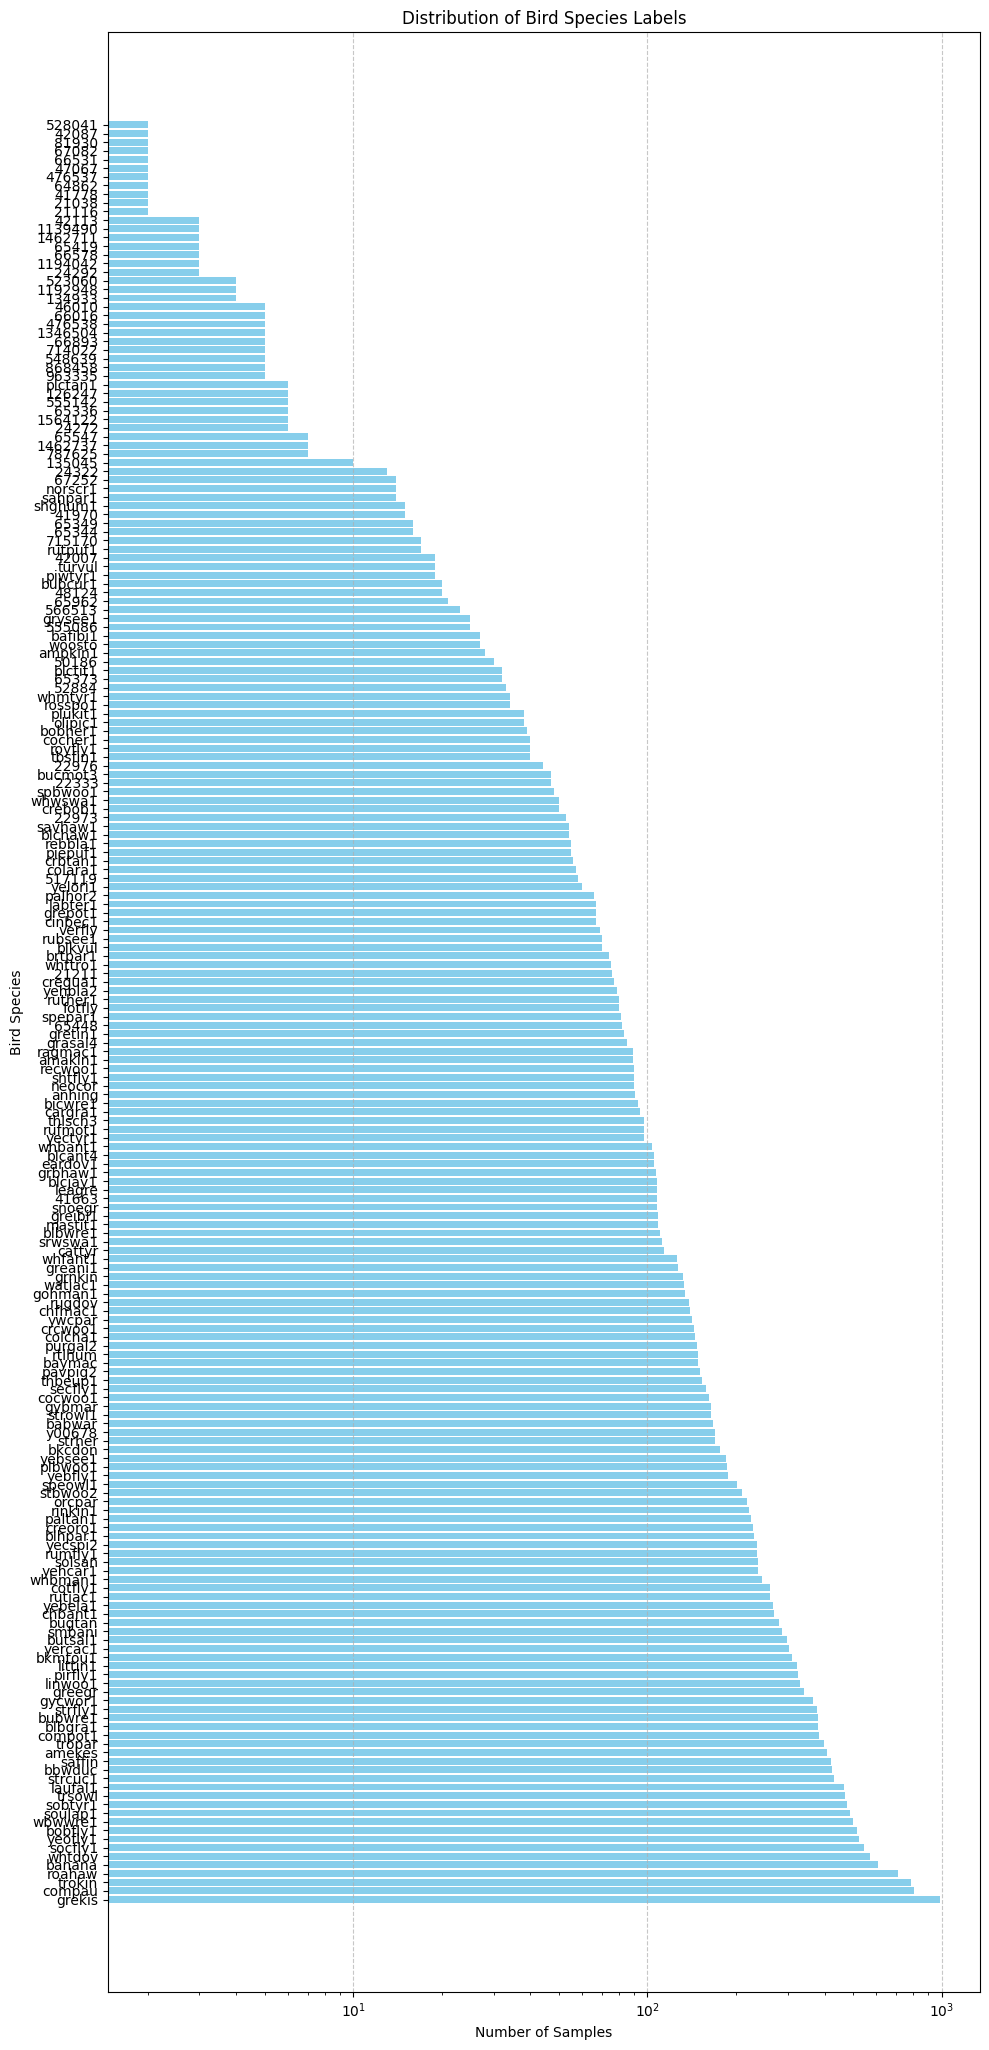

Returning 28579 processed filtered labels


Loading training spectrograms:   0%|          | 0/28579 [00:00<?, ?it/s]


============================== Fold 4 ==============================
Training set: 22864 samples
Validation set: 5715 samples

-------------------- Training Model --------------------
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 4
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 4


Training:   0%|          | 0/714 [00:00<?, ?it/s]

W0601 13:29:30.623000 32928 torch\_inductor\utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 1 Summary ---
Train Loss: 0.0328, Train AUC: 0.4975
Val Loss: 0.0245, Val AUC: 0.6799
LR: 0.000500, Epoch Time: 4.44m
Valid Classes: 197
New best AUC: 0.6799 at epoch 1

Epoch 2/5 | Fold 4


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 2 Summary ---
Train Loss: 0.0235, Train AUC: 0.6699
Val Loss: 0.0187, Val AUC: 0.8611
LR: 0.000500, Epoch Time: 1.39m
Valid Classes: 197
New best AUC: 0.8611 at epoch 2

Epoch 3/5 | Fold 4


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 3 Summary ---
Train Loss: 0.0209, Train AUC: 0.7501
Val Loss: 0.0153, Val AUC: 0.9174
LR: 0.000500, Epoch Time: 1.40m
Valid Classes: 197
New best AUC: 0.9174 at epoch 3

Epoch 4/5 | Fold 4


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 4 Summary ---
Train Loss: 0.0191, Train AUC: 0.7348
Val Loss: 0.0136, Val AUC: 0.9369
LR: 0.000500, Epoch Time: 1.40m
Valid Classes: 197
New best AUC: 0.9369 at epoch 4

Epoch 5/5 | Fold 4


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 5 Summary ---
Train Loss: 0.0178, Train AUC: 0.7941
Val Loss: 0.0128, Val AUC: 0.9394
LR: 0.000452, Epoch Time: 1.41m
Valid Classes: 197
New best AUC: 0.9394 at epoch 5

*** FOLD 4 COMPLETE ***
Best AUC: 0.9394 at epoch 5
Fold training time: 10.9 minutes

============================== Fold 3 ==============================
Training set: 22863 samples
Validation set: 5716 samples

-------------------- Training Model --------------------

============================== Fold 3 ==============================
Training set: 22863 samples
Validation set: 5716 samples

-------------------- Training Model --------------------
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 3
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 3


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 1 Summary ---
Train Loss: 0.0325, Train AUC: 0.5200
Val Loss: 0.0249, Val AUC: 0.6624
LR: 0.000500, Epoch Time: 1.63m
Valid Classes: 196
New best AUC: 0.6624 at epoch 1

Epoch 2/5 | Fold 3


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 2 Summary ---
Train Loss: 0.0239, Train AUC: 0.6501
Val Loss: 0.0202, Val AUC: 0.8314
LR: 0.000500, Epoch Time: 1.45m
Valid Classes: 196
New best AUC: 0.8314 at epoch 2

Epoch 3/5 | Fold 3


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 3 Summary ---
Train Loss: 0.0220, Train AUC: 0.6673
Val Loss: 0.0175, Val AUC: 0.8850
LR: 0.000500, Epoch Time: 1.43m
Valid Classes: 196
New best AUC: 0.8850 at epoch 3

Epoch 4/5 | Fold 3


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 4 Summary ---
Train Loss: 0.0205, Train AUC: 0.8679
Val Loss: 0.0160, Val AUC: 0.9058
LR: 0.000500, Epoch Time: 1.42m
Valid Classes: 196
New best AUC: 0.9058 at epoch 4

Epoch 5/5 | Fold 3


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 5 Summary ---
Train Loss: 0.0193, Train AUC: 0.8566
Val Loss: 0.0147, Val AUC: 0.9226
LR: 0.000452, Epoch Time: 1.41m
Valid Classes: 196
New best AUC: 0.9226 at epoch 5

*** FOLD 3 COMPLETE ***
Best AUC: 0.9226 at epoch 5
Fold training time: 8.1 minutes

============================== Fold 2 ==============================
Training set: 22863 samples
Validation set: 5716 samples

-------------------- Training Model --------------------

============================== Fold 2 ==============================
Training set: 22863 samples
Validation set: 5716 samples

-------------------- Training Model --------------------
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 2
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 2


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 1 Summary ---
Train Loss: 0.0327, Train AUC: 0.5052
Val Loss: 0.0255, Val AUC: 0.6367
LR: 0.000500, Epoch Time: 1.60m
Valid Classes: 196
New best AUC: 0.6367 at epoch 1

Epoch 2/5 | Fold 2


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 2 Summary ---
Train Loss: 0.0245, Train AUC: 0.6505
Val Loss: 0.0212, Val AUC: 0.7985
LR: 0.000500, Epoch Time: 1.41m
Valid Classes: 196
New best AUC: 0.7985 at epoch 2

Epoch 3/5 | Fold 2


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 3 Summary ---
Train Loss: 0.0225, Train AUC: 0.6639
Val Loss: 0.0184, Val AUC: 0.8703
LR: 0.000500, Epoch Time: 1.42m
Valid Classes: 196
New best AUC: 0.8703 at epoch 3

Epoch 4/5 | Fold 2


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 4 Summary ---
Train Loss: 0.0210, Train AUC: 0.7001
Val Loss: 0.0168, Val AUC: 0.8918
LR: 0.000500, Epoch Time: 1.42m
Valid Classes: 196
New best AUC: 0.8918 at epoch 4

Epoch 5/5 | Fold 2


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 5 Summary ---
Train Loss: 0.0200, Train AUC: 0.8171
Val Loss: 0.0157, Val AUC: 0.9126
LR: 0.000452, Epoch Time: 1.42m
Valid Classes: 196
New best AUC: 0.9126 at epoch 5

*** FOLD 2 COMPLETE ***
Best AUC: 0.9126 at epoch 5
Fold training time: 8.0 minutes

============================== Fold 1 ==============================
Training set: 22863 samples
Validation set: 5716 samples

-------------------- Training Model --------------------

============================== Fold 1 ==============================
Training set: 22863 samples
Validation set: 5716 samples

-------------------- Training Model --------------------
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 1
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 1


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 1 Summary ---
Train Loss: 0.0330, Train AUC: 0.5196
Val Loss: 0.0261, Val AUC: 0.5848
LR: 0.000500, Epoch Time: 1.60m
Valid Classes: 195
New best AUC: 0.5848 at epoch 1

Epoch 2/5 | Fold 1


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 2 Summary ---
Train Loss: 0.0251, Train AUC: 0.5913
Val Loss: 0.0222, Val AUC: 0.8032
LR: 0.000500, Epoch Time: 1.39m
Valid Classes: 195
New best AUC: 0.8032 at epoch 2

Epoch 3/5 | Fold 1


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 3 Summary ---
Train Loss: 0.0232, Train AUC: 0.7067
Val Loss: 0.0200, Val AUC: 0.8564
LR: 0.000500, Epoch Time: 1.40m
Valid Classes: 195
New best AUC: 0.8564 at epoch 3

Epoch 4/5 | Fold 1


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 4 Summary ---
Train Loss: 0.0219, Train AUC: 0.6830
Val Loss: 0.0185, Val AUC: 0.8799
LR: 0.000500, Epoch Time: 1.41m
Valid Classes: 195
New best AUC: 0.8799 at epoch 4

Epoch 5/5 | Fold 1


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 5 Summary ---
Train Loss: 0.0208, Train AUC: 0.7403
Val Loss: 0.0169, Val AUC: 0.9053
LR: 0.000452, Epoch Time: 1.40m
Valid Classes: 195
New best AUC: 0.9053 at epoch 5

*** FOLD 1 COMPLETE ***
Best AUC: 0.9053 at epoch 5
Fold training time: 7.9 minutes

============================== Fold 0 ==============================
Training set: 22863 samples
Validation set: 5716 samples

-------------------- Training Model --------------------

============================== Fold 0 ==============================
Training set: 22863 samples
Validation set: 5716 samples

-------------------- Training Model --------------------
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 0
Model compiled successfully with backend 'inductor', mode 'default'

Epoch 1/5 | Fold 0


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 1 Summary ---
Train Loss: 0.0330, Train AUC: 0.5038
Val Loss: 0.0263, Val AUC: 0.5685
LR: 0.000500, Epoch Time: 1.57m
Valid Classes: 196
New best AUC: 0.5685 at epoch 1

Epoch 2/5 | Fold 0


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 2 Summary ---
Train Loss: 0.0254, Train AUC: 0.5808
Val Loss: 0.0232, Val AUC: 0.7624
LR: 0.000500, Epoch Time: 1.39m
Valid Classes: 196
New best AUC: 0.7624 at epoch 2

Epoch 3/5 | Fold 0


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 3 Summary ---
Train Loss: 0.0237, Train AUC: 0.6457
Val Loss: 0.0208, Val AUC: 0.8251
LR: 0.000500, Epoch Time: 1.39m
Valid Classes: 196
New best AUC: 0.8251 at epoch 3

Epoch 4/5 | Fold 0


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 4 Summary ---
Train Loss: 0.0225, Train AUC: 0.7977
Val Loss: 0.0193, Val AUC: 0.8573
LR: 0.000500, Epoch Time: 1.39m
Valid Classes: 196
New best AUC: 0.8573 at epoch 4

Epoch 5/5 | Fold 0


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 5 Summary ---
Train Loss: 0.0214, Train AUC: 0.6982
Val Loss: 0.0182, Val AUC: 0.8812
LR: 0.000452, Epoch Time: 1.39m
Valid Classes: 196
New best AUC: 0.8812 at epoch 5

*** FOLD 0 COMPLETE ***
Best AUC: 0.8812 at epoch 5
Fold training time: 7.8 minutes

CROSS-VALIDATION RESULTS:
Fold 0: 0.9394 (Best epoch: 5)
Fold 1: 0.9226 (Best epoch: 5)
Fold 2: 0.9126 (Best epoch: 5)
Fold 3: 0.9053 (Best epoch: 5)
Fold 4: 0.8812 (Best epoch: 5)

Mean AUC: 0.9122 ± 0.0193
Min AUC: 0.8812
Max AUC: 0.9394

CROSS-VALIDATION RESULTS:
Fold 0: 0.9394 (Best epoch: 5)
Fold 1: 0.9226 (Best epoch: 5)
Fold 2: 0.9126 (Best epoch: 5)
Fold 3: 0.9053 (Best epoch: 5)
Fold 4: 0.8812 (Best epoch: 5)

Mean AUC: 0.9122 ± 0.0193
Min AUC: 0.8812
Max AUC: 0.9394
Plotting ROC curves for folds: [0, 1, 2, 3, 4]
Plotting ROC curves for folds: [0, 1, 2, 3, 4]
Metrics saved to output/metrics//metrics_20250601_132509.csv

Training complete!
Config saved to output/configs/config_20250601_132509_efficientnet_b0.json

Fi

In [8]:
if __name__ == "__main__":
    print("\nLoading training data...")
    train_df = pd.read_csv(cfg.train_csv)

    soundscape_df = None
    if cfg.use_external_pseudolabels:
        print(f"Will use external pseudolabels from: {cfg.external_pseudolabels}")
        soundscape_df = pd.read_csv(cfg.external_pseudolabels)

    print("\nStarting training...")
    print(f"LOAD_DATA is set to {cfg.LOAD_DATA}")

    # Run training and get best scores
    best_scores = run_training(train_df, cfg, soundscape_df=soundscape_df)
    
    print("\nTraining complete!")
    cfg.save_config()
    
    # Additional analysis
    print(f"\nFinal Results Summary:")
    print(f"Best scores per fold: {[f'{score:.4f}' for score in best_scores]}")
    print(f"Cross-validation mean: {np.mean(best_scores):.4f} ± {np.std(best_scores):.4f}")

In [9]:
timm.list_models(pretrained=True)

['aimv2_1b_patch14_224.apple_pt',
 'aimv2_1b_patch14_336.apple_pt',
 'aimv2_1b_patch14_448.apple_pt',
 'aimv2_3b_patch14_224.apple_pt',
 'aimv2_3b_patch14_336.apple_pt',
 'aimv2_3b_patch14_448.apple_pt',
 'aimv2_huge_patch14_224.apple_pt',
 'aimv2_huge_patch14_336.apple_pt',
 'aimv2_huge_patch14_448.apple_pt',
 'aimv2_large_patch14_224.apple_pt',
 'aimv2_large_patch14_224.apple_pt_dist',
 'aimv2_large_patch14_336.apple_pt',
 'aimv2_large_patch14_336.apple_pt_dist',
 'aimv2_large_patch14_448.apple_pt',
 'bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patc

## Cross-Validation Analysis

Before training, let's analyze class distribution across folds to understand potential causes of variance.

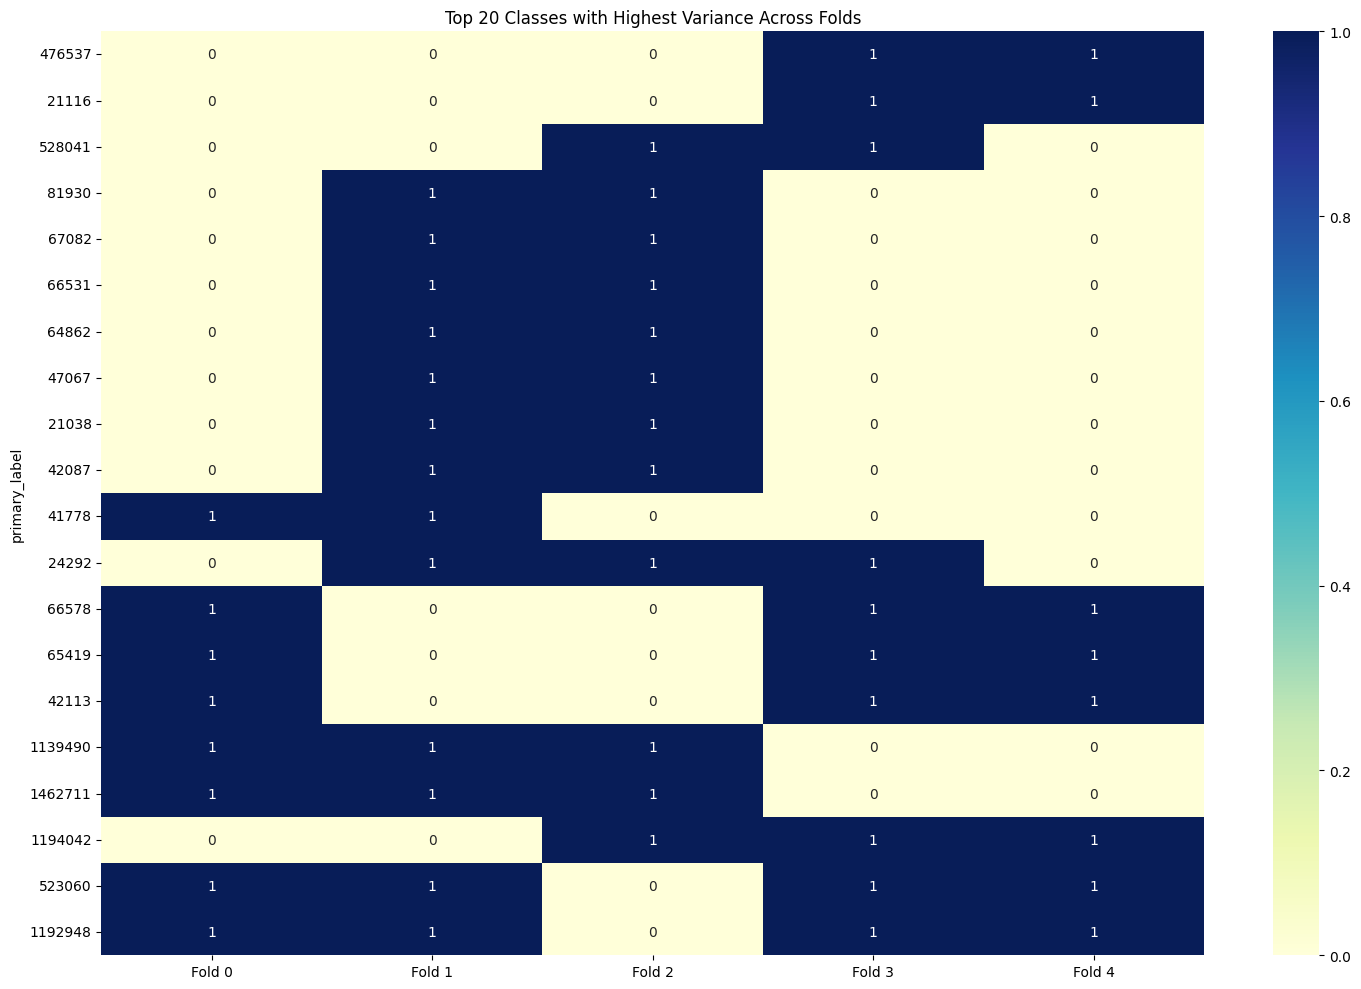

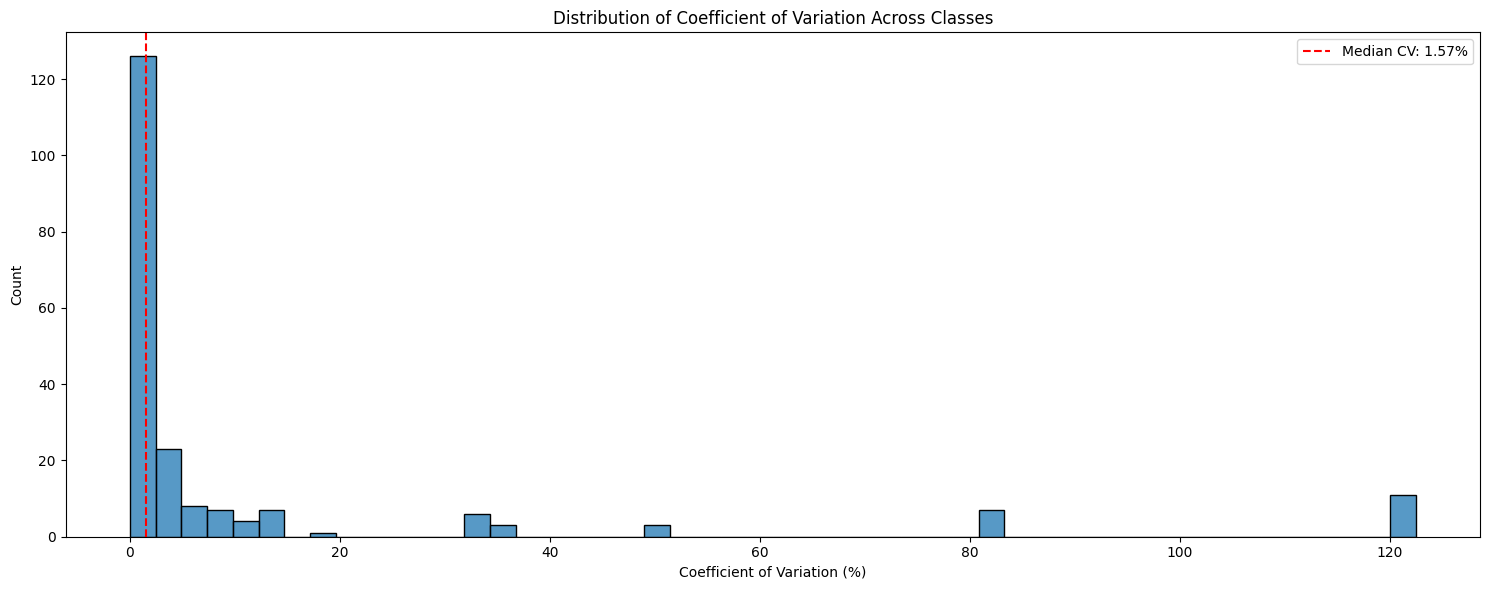

Top 10 most variable classes across folds:


,Mean,Std,CV
primary_label,,,
476537,0.4,0.489898,122.474487
21116,0.4,0.489898,122.474487
528041,0.4,0.489898,122.474487
81930,0.4,0.489898,122.474487
67082,0.4,0.489898,122.474487
66531,0.4,0.489898,122.474487
64862,0.4,0.489898,122.474487
47067,0.4,0.489898,122.474487
21038,0.4,0.489898,122.474487


In [10]:
def analyze_fold_distributions(df, cfg):
    """Analyze and visualize class distributions across folds"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create folds
    skf = StratifiedKFold(n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    fold_indices = list(skf.split(df, df['primary_label']))
    
    # Count samples per class per fold
    all_labels = df['primary_label'].unique()
    fold_class_counts = {}
    
    for fold_idx, (train_idx, val_idx) in enumerate(fold_indices):
        val_df = df.iloc[val_idx]
        class_counts = val_df['primary_label'].value_counts()
        fold_class_counts[f'Fold {fold_idx}'] = class_counts
    
    # Convert to DataFrame for easier plotting
    fold_df = pd.DataFrame(fold_class_counts)
    fold_df = fold_df.fillna(0)  # Replace NaN with 0
    
    # Calculate coefficient of variation (CV) for each class across folds
    fold_df['Mean'] = fold_df.mean(axis=1)
    fold_df['Std'] = fold_df.std(axis=1)
    fold_df['CV'] = (fold_df['Std'] / fold_df['Mean']) * 100  # CV as percentage
    
    # Sort by CV to identify classes with highest variance
    fold_df = fold_df.sort_values('CV', ascending=False)
    
    # Visualize distribution for top 20 most variable classes
    plt.figure(figsize=(15, 10))
    sns.heatmap(fold_df.drop(['Mean', 'Std', 'CV'], axis=1).head(20), 
                annot=True, cmap='YlGnBu', fmt='.0f')
    plt.title('Top 20 Classes with Highest Variance Across Folds')
    plt.tight_layout()
    plt.show()
    
    # Plot coefficient of variation distribution
    plt.figure(figsize=(15, 6))
    sns.histplot(fold_df['CV'].dropna(), bins=50)
    plt.title('Distribution of Coefficient of Variation Across Classes')
    plt.xlabel('Coefficient of Variation (%)')
    plt.axvline(fold_df['CV'].median(), color='red', linestyle='--', 
                label=f'Median CV: {fold_df["CV"].median():.2f}%')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Return problematic classes
    return fold_df

# Run the analysis before training
fold_analysis = analyze_fold_distributions(train_df, cfg)
print(f"Top 10 most variable classes across folds:")
display(fold_analysis[['Mean', 'Std', 'CV']].head(10))